In [43]:
import torch
from d2l import torch as d2l
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
import torchvision

In [44]:
#设计残差块
class Residual(nn.Module):
    def __init__(self,input_channels,output_channels,use_1x1conv=False,strides=1):
        super().__init__()
        self.conv1=nn.Conv2d(input_channels,output_channels,kernel_size=3,padding=1,stride=strides)
        self.conv2=nn.Conv2d(output_channels,output_channels,kernel_size=3,padding=1)
        self.use_1x1conv=use_1x1conv
        if use_1x1conv:
            self.conv3=nn.Conv2d(input_channels,output_channels,kernel_size=1,stride=strides)
        self.bn1=nn.BatchNorm2d(output_channels)
        self.bn2=nn.BatchNorm2d(output_channels)
    def forward(self,X):
        Y=F.relu(self.bn1(self.conv1(X)))
        Y=self.bn2(self.conv2(Y))
        if self.use_1x1conv:
            X=self.conv3(X)
        Y+=X
        return F.relu(Y)

In [45]:
blk=Residual(3,3)
X=torch.rand(4,3,6,6)
Y=blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

In [46]:
#ResNet的第一个Stage
b1=nn.Sequential(nn.Conv2d(1,64,kernel_size=7,padding=3,stride=2),nn.BatchNorm2d(64),
                 nn.ReLU(),nn.MaxPool2d(kernel_size=3,stride=2,padding=1) )
def resnet_block(input_channels,output_channels,num_residuals,first_block=False):
    blk=[]
    for i in range(num_residuals):
        if i==0 and not first_block:
            blk.append(Residual(input_channels,output_channels,use_1x1conv=True,strides=2))
        else:
            blk.append(Residual(output_channels,output_channels))
    return blk
b2=nn.Sequential(*resnet_block(64,64,2,first_block=True))
b3=nn.Sequential(*resnet_block(64,128,2))
b4=nn.Sequential(*resnet_block(128,256,2))
b5=nn.Sequential(*resnet_block(256,512,2))

resnet=nn.Sequential(b1,b2,b3,b4,b5,nn.AdaptiveAvgPool2d((1,1)),nn.Flatten(),nn.Linear(512,10))

In [47]:
X=torch.rand(size=(1,1,94,94))
for layer in resnet:
    X=layer(X)
    print(layer.__class__.__name__,"output shape:\t",X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 128, 12, 12])
Sequential output shape:	 torch.Size([1, 256, 6, 6])
Sequential output shape:	 torch.Size([1, 512, 3, 3])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


In [48]:
#加载数据集
def load_data_fashion_mnist(batch_size,resize=None):
    if resize:
        trans=transforms.Compose([transforms.ToTensor(),transforms.Resize(resize)])
    else:
        trans=transforms.ToTensor()
    train_dataset=torchvision.datasets.FashionMNIST(root="C:/Users/Administrator/Desktop/datasets/fashionMnist_download",train=True,transform=trans,download=False)
    test_dataset=torchvision.datasets.FashionMNIST(root="C:/Users/Administrator/Desktop/datasets/fashionMnist_download",train=False,transform=trans,download=False)
    return torch.utils.data.DataLoader(train_dataset,batch_size,shuffle=True,num_workers=0),torch.utils.data.DataLoader(test_dataset,batch_size,shuffle=False,num_workers=0)

In [49]:
train_iter,test_iter=load_data_fashion_mnist(256,(96,96))

loss 0.018, train acc 0.995, test acc 0.912
1855.3 examples/sec on cuda:0


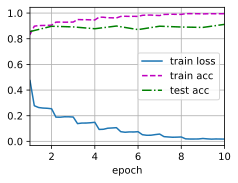

In [50]:
num_epochs=10
lr=0.05
batch_size=256
d2l.train_ch6(resnet,train_iter,test_iter,num_epochs,lr,"cuda:0")